# Data Analytics

In [408]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as st
import scipy.optimize as opt
import scipy.integrate as integrate
from scipy.optimize import minimize
from uncertainties import ufloat
from uncertainties import unumpy
%matplotlib inline

# Step 0: Link the working directory

In [409]:
# We change the directory to the current working directory
os.chdir(os.getcwd())

# Step 1: Load your data 

In [428]:
#Load and visualize preliminaries by creating a pandas dataframe objects

# get the folder path

DATA_PATH = " " 

# different .csv files 
FILE1 = "data.csv"
FILE2 = "balloondata.csv"

# method to load data - call method with file name 
def load_data(file_name, data_path=DATA_PATH):
    csv_path = os.path.join(data_path, file_name)
    return pd.read_csv(csv_path)

In [416]:
data = load_data(FILE1)
balloon = load_data(FILE2)
raw = load_data(FILE3)
formatted = load_data(FILE4)

In [414]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 2 columns):
Fringes     29 non-null int64
Pressure    29 non-null float64
dtypes: float64(1), int64(1)
memory usage: 544.0 bytes


In [355]:
data.describe()

Fringes   Pressure
count  29.000000  29.000000
mean    7.241379  18.241379
std     4.976051  13.720827
min     0.000000   0.000000
25%     6.000000  11.500000
50%     9.000000  20.000000
75%    12.000000  30.000000
max    15.000000  42.000000

In [356]:
data.head()

Fringes  Pressure
0        0       0.0
1        6      12.0
2        9      20.0
3       12      30.0
4        0       0.0

In [357]:
balloon.head()

phi  correction
0   45       36.70
1   50       43.72
2   55       52.35
3   60       63.41
4   65       78.35

In [421]:
data

Fringes  Pressure
0         0       0.0
1         6      12.0
2         9      20.0
3        12      30.0
4         0       0.0
5         6      11.5
6         9      22.5
7        12      32.5
8        15      38.5
9         0       0.0
10        6      12.0
11        9      24.0
12        0       0.0
13        6      13.0
14        9      22.0
15        0       0.0
16        6      12.0
17        9      23.0
18       12      32.0
19       15      41.0
20        0       0.0
21        6      13.0
22        9      26.0
23       12      34.0
24        0       0.0
25        6      12.0
26        9      22.0
27       12      34.0
28       15      42.0

# Step 2: Analyze and clean the data

Make the raw data easier to understand.

In [358]:
# we take out pressure readings to be our average values
mean = data.groupby(data["Fringes"]).mean()
pressure = np.array(mean["Pressure"])
fringes = mean.index.values
pressure, fringes

(array([ 0.        , 12.21428571, 22.78571429, 32.5       , 40.5       ]),
 array([ 0,  6,  9, 12, 15]))

In [359]:
std = data.groupby(data["Fringes"]).std(ddof=1)
std = std.fillna(0)
std = np.array(std["Pressure"])
std

array([0.        , 0.56694671, 1.8676443 , 1.6583124 , 1.80277564])

# Step 3: Plot the data

Plot the raw data.

In [360]:
# raw data plot - no bells and whistles
yraw = np.array(data["Fringes"])
xraw = np.array(data["Pressure"])

plt.plot(xraw, yraw, 'o')
plt.show()

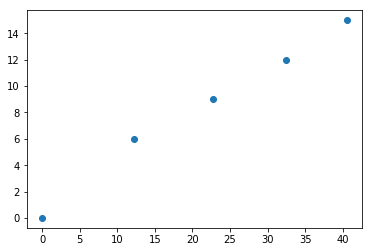

In [361]:
plt.plot(pressure, fringes, 'o')
plt.show()

# Applying a model to the data

This step involves applying a regression algorithm for finding a curve of best fist for the data.

In [362]:
# CREATE THE MODEL
def model(x, b0, b1):
    # x: the data
    # b's: the model parameters
    model = b0*x + b1
    return model

In [363]:
# OPTIMIZE THE MODEL

# data points
x1 = pressure
y1 = fringes
sigmaT = [1 for i in range(len(pressure))]
params1, cov1 = opt.curve_fit(model, xdata=x1, ydata=y1, sigma=None, p0=[1,1])
params2, cov2 = opt.curve_fit(model, xdata=y1, ydata=x1, sigma=sigmaT, p0=[1,1])

In [364]:
# optimal parameters for model
print('Optimal parameters 1: ', params1)
print('Optimal parameters 2: ', params2)

Optimal parameters 1:  [0.35719907 0.68450007]
Optimal parameters 2:  [ 2.76769627 -1.64864865]


In [365]:
# the covariance matrix
print("Cov. Matrix 1: \n", cov1)

Cov. Matrix 1: 
 [[ 0.00048963 -0.01057602]
 [-0.01057602  0.32950953]]


In [366]:
# uncertainties in the optimal parameters
unc1 = np.sqrt(np.diag(cov1))
unc2 = np.sqrt(np.diag(cov2))
print('Uncertainty in parameters 1: ', unc1)
print('Uncertainty in parameters 2: ', unc2)

Uncertainty in parameters 1:  [0.0221276 0.5740292]
Uncertainty in parameters 2:  [0.17145198 1.69034601]


In [367]:

# generate some data
x = np.arange(0, 10, 0.2)
y = np.sin(x)

# plot setting
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 

# data plot
ax0 = plt.subplot(gs[0])
ax0.plot(x1, model(x1, *params1), '-', color='grey', label='Best Fit')
ax0.errorbar(x1, y1, xerr=1, fmt='o', label='Data')
ax0.set_title('Fringes as a Function of Pressure', fontsize='14')
ax0.set_ylabel('Number of Fringes', fontsize='14')
ax0.set_xlabel('Pressure (cmHg)', fontsize='14')
ax0.grid()

# uncertainties
minSlope = params1[0] - unc1[0]
minInitial = params1[1] - unc1[1]
minParams1 = [minSlope, minInitial]

maxSlope = params1[0] + unc1[0]
maxInitial = params1[1] + unc1[1]
maxParams1 = [maxSlope, maxInitial]

# max/min lines
ax0.plot(x1, model(x1, *minParams1), '--', color='orange', label='Max/Min Line')
ax0.plot(x1, model(x1, *maxParams1), '--', color='orange')
plt.legend()

# residual plot
ax1 = plt.subplot(gs[1])
ax1.errorbar(x1 - model(y1, *params2), y1, xerr=1, fmt='o', color='red', label='Residual')
ax1.set_xlabel('Residuals', fontsize='14')
ax1.grid()
ax1.legend(loc='best')

# label sizes
ax0.tick_params(axis='both', labelsize='12')
ax1.tick_params(axis='both', labelsize='12')

plt.tight_layout()
plt.savefig('fringesVpressure.png', dpi=300)
plt.show()

# Step 4: Perform calculations 

Perform statistical calculations on the cleaned data.

In [368]:
# chi-squred test for the best fit
# requires array inputs
def chisquared(y, model, error):
    arr = []
    for i in range(len(y)):
        val = (y[i] - model[i])**2 / error[i]
        arr.append(val)
    chi2 = np.sum(np.array(arr))
    return chi2


In [369]:
# chi2 calculation
error = [1 for i in range(len(fringes))]
chi2 = chisquared(pressure, model(fringes, *params2), error)
print('chi2: ', chi2)

chi2:  11.746552675124109


In [424]:
# pressure as a function of height 
def pressureFromHeight(height):
    g = 9.81 # m/s^2
    M = 0.0289644 # kg/mol - molar mass of Earth's air
    Hb = 0 # m - height at bottom of level b
    R = 8.3144598 # J/mol/K
    Tb = 298 # K - standard temperature
    Lb = -0.0065 # K/m - lapse rate
    Pb = 76 # cmHg - static pressure 
    P = Pb * np.exp( (-g * M * (height - Hb)) / (R * Tb) )
    #P = Pb * ((Tb / (Tb + Lb*(height - Hb)))**((g*M)/(R*Lb)))
    return P

In [425]:
# index of refraction function
def index(height, params=params1):
    pressure = pressureFromHeight(height)
    wave = 632.8*(10**-9)
    t = 3*(10**-2)
    n = (wave / (2 * t))*model(pressure, *params) + 1
    return n

def maxIndex(height, params=maxParams1):
    pressure = pressureFromHeight(height)
    wave = 632.8*(10**-9)
    t = 3*(10**-2)
    n = (wave / (2 * t))*model(pressure,*params) + 1
    return n

def minIndex(height, params=minParams1):
    pressure = pressureFromHeight(height)
    wave = 632.8*(10**-9)
    t = 3*(10**-2)
    n = (wave / (2 * t))*model(pressure, *params) + 1
    return n

In [426]:
# index of air
nAir = index(0)
minAir = minIndex(0)
maxAir = maxIndex(0)
print('Index of Air: ', nAir)
print('Difference Between Max Index of Air:', maxAir - nAir)

Index of Air:  1.0002935309191363
Difference Between Max Index of Air: 2.3790399136691676e-05


In [429]:
# error in the index of air
p = ufloat(76, 1)
t = ufloat(0.03,0.01)
wave = ufloat(632.8 * 10**-9, 0.1* 10**-9)
paramsUfloat = np.array([ufloat(params1[0], unc1[0]), ufloat(params1[1], unc1[1])])
paramsUfloat
nA = (wave / (2 * t))*model(p, *paramsUfloat) + 1
print("Uncertainty in the Index of Air: ", nA)

Uncertainty in the Index of Air:  1.00029+/-0.00010


In [374]:
# zscore function
def zscore(true, mean, std):
    zscore = (mean - true) / std
    return zscore

In [430]:
# zscore for air
trueIndexAir = 1.000293
zscoreAir = zscore(trueIndexAir, 1.0003, 0.0001)
print("Zscore for Index of Air: ", zscoreAir)

Zscore for Index of Air:  0.06999999999868223


In [376]:
# function to integrate
# r is the radius from Earth's center
def integrand(r, phi, index):
    # CONSTANTS
    r0 = 6371000
    n0 = index(0)
    
    # INTEGRAND FUNCTION
    numerator = np.sin(phi)
    denominator = r * np.sqrt(((r*index(r-r0))/(r0*n0))**2 - np.sin(phi)**2)
    return numerator / denominator
    

In [377]:
# the integral as a function
# returns a tuple with:
# 1. the value of the integral
# 2. the error on the integral
def integral(initial, r, phi, index):
    # INTEGRAL FUNCTION
    I = integrate.quad(integrand, initial, r, args=(phi, index))
    return I 

In [378]:
# refraction as a function of phi
initial = 6371000
final = 150*10**9
phi = np.arange(0, np.pi/2, np.pi/180)
refraction = []
maxRefraction = []
minRefraction = []
arcConvert = 648000/np.pi # arcseconds
for i in phi:
    val = integral(initial, final, i, index)[0] - i
    valMax = integral(initial, final, i, maxIndex)[0] - i 
    valMin = integral(initial, final, i, minIndex)[0] - i
    refraction.append(val*arcConvert)
    maxRefraction.append(valMax*arcConvert)
    minRefraction.append(valMin*arcConvert)

In [379]:
# real data
phiReal = balloon['phi']
correctionReal = balloon['correction']

In [380]:
balloon

phi  correction
0   45       36.70
1   50       43.72
2   55       52.35
3   60       63.41
4   65       78.35
5   70      100.00
6   75      134.70
7   80      200.00
8   85      361.80

In [381]:
%matplotlib 
phiDegree = phi * (180/np.pi)
plt.plot(phiDegree[:-4], refraction[:-4], color='black', label='Correction')
plt.plot(phiDegree[:-4], maxRefraction[:-4], '--', color='green', label='Max Refraction')
plt.plot(phiDegree[:-4], minRefraction[:-4], '--', color='orange', label='Min Refraction')
plt.plot(phiReal, correctionReal, '--', color='purple', label='Balloon Data')
plt.legend()
plt.grid()

plt.xlabel('Apparent Angle $\phi$ (Degrees)', size='14')
plt.ylabel('Angular Correction (Arcsec)', size='14')

plt.xticks(size='12')
plt.yticks(size='12')

#plt.savefig('correctionVangle.png', dpi=300)
plt.show()

Using matplotlib backend: MacOSX


In [431]:
d = {'Apparent Angle (Degrees)':phiDegree, 'Angular Correction (Arcsec)':refraction, 'Min Angular Correction (Arcsec)':minRefraction, 'Max Angular Correction (Arcsec)':maxRefraction}
table = pd.DataFrame(data=d)
#table.to_csv('tableofvalues.csv')
table

Angular Correction (Arcsec)  Apparent Angle (Degrees)  \
0                      0.000000                       0.0   
1                      0.877726                       1.0   
2                      1.756127                       2.0   
3                      2.635879                       3.0   
4                      3.517662                       4.0   
5                      4.402159                       5.0   
6                      5.290061                       6.0   
7                      6.182065                       7.0   
8                      7.078879                       8.0   
9                      7.981221                       9.0   
10                     8.889823                      10.0   
11                     9.805429                      11.0   
12                    10.728804                      12.0   
13                    11.660726                      13.0   
14                    12.601999                      14.0   
15                    13.553447                      15.0   
16                    14.515918                      16.0   
17                    15.490291                      17.0   
18                    16.477474                      18.0   
19                    17.478407                      19.0   
20                    18.494067                      20.0   
21                    19.525471                      21.0   
22                    20.573680                      22.0   
23                    21.639800                      23.0   
24                    22.724988                      24.0   
25                    23.830458                      25.0   
26                    24.957483                      26.0   
27                    26.107404                      27.0   
28                    27.281632                      28.0   
29                    28.481654                      29.0   
..                          ...                       ...   
60                    94.207181                      60.0   
61                    98.332198                      61.0   
62                   102.728576                      62.0   
63                   107.425849                      63.0   
64                   112.457968                      64.0   
65                   117.864158                      65.0   
66                   123.689978                      66.0   
67                   129.988647                      67.0   
68                   136.822721                      68.0   
69                   144.266216                      69.0   
70                   152.407343                      70.0   
71                   161.352053                      71.0   
72                   171.228695                      72.0   
73                   182.194194                      73.0   
74                   194.442383                      74.0   
75                   208.215386                      75.0   
76                   223.819420                      76.0   
77                   241.647145                      77.0   
78                   262.209880                      78.0   
79                   286.185082                      79.0   
80                   314.488054                      80.0   
81                   348.383263                      81.0   
82                   389.662648                      82.0   
83                   440.941570                      83.0   
84                   506.170657                      84.0   
85                   591.564473                      85.0   
86                   707.384929                      86.0   
87                   871.610051                      87.0   
88                  1118.160174                      88.0   
89                  1517.561281                      89.0   

    Max Angular Correction (Arcsec)  Min Angular Correction (Arcsec)  
0                          0.000000                         0.000000  
1                          0.941564                         0.813887  
2       